# СТЕГОАНАЛИЗ ИЗОБРАЖЕНИЙ С ПОМОЩЬЮ ГЛУБОКОГО МАШИННОГО ОБУЧЕНИЯ 

## Аннотация
Рассматривается современное состояние проблемы стегоанализа цифровых изображений, направленной на исследование и разработку эффективных методов выявления стеганографически скрытых (визуально незаметных) сообщений в контейнерах- изображениях.

## Содержание

1. [Импорт необходимых библиотек](#first)
2. [Получение и предобработка данных](#second)
    1. [Алгоритм WOW](#wow_algos)
    2. [Встраивание и предобработка данных](#data_prepare)
3. [DataLoader - структурирование данных](#data_loader)
4. [Сверточная нейросеть](#neural_net)
5. [Обучение и валидация модели](#tests)
6. [Тесты нейросети с различными параметрами встраивания](#wow_test)
    1. [Тесты на датасете с картинками без граней](#wow_test_1)
    2. [Тесты на датасете с картинками с гранями](#wow_test_2)

## 1. Импорт необходимых библиотек
<span id="first"></span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.signal import convolve2d
from scipy.interpolate import make_interp_spline
from skimage import io, transform
from IPython.display import clear_output

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score

import torch, torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

import os
import string
import random
from tqdm import tqdm
import time
import warnings


In [2]:
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (3,3)

## 2. Получение и предобработка данных

### 2.1 Алгоримт  WOW
<span id="wow_algos"></span>

In [3]:
def WOW(cover, payload:float, params:int):
    # Input:  cover ... картинка
    #         payload ..... информация в битах на пиксель
    # Output: stego ....... конечная картинка с встроенной информацией

    # Получение 2D вейвлет-фильтров
    # 1D фильтр высокочастотного разложения
    hpdf = np.matrix([[-0.0544158422, 0.3128715909, -0.6756307363, 0.5853546837, 0.0158291053, -0.2840155430, 
                    -0.0004724846, 0.1287474266, 0.0173693010, -0.0440882539, -0.0139810279, 0.0087460940,
                    0.0048703530, -0.0003917404, -0.0006754494, -0.0001174768]])
    
    # 1D фильтр низкочастотного разложения
    lpdf = np.matrix((-1) ** np.array(range(hpdf.shape[1])) * np.fliplr(hpdf).A)
    # построение двумерных вейвлет-фильтров
    F = []
    F.append(lpdf.T * hpdf)
    F.append(hpdf.T * lpdf)
    F.append(hpdf.T * hpdf)

    ## Получение затрат на встраивание
    cover = cover.astype('float64')
    p = params
    wetCost = 10 ** 10
    sizeCover = cover.shape

    # добавление padding 
    padSize = np.max(np.concatenate([F[0].shape, F[1].shape, F[2].shape]))
    coverPadded = np.pad(cover, ((padSize, padSize), (padSize, padSize)), 'symmetric')

    # вычисление остатка направленности и пригодность xi для каждого фильтра
    xi = []
    for fIndex in range(0, 3):
        # вычисление остатка
        R = convolve2d(coverPadded, F[fIndex], 'same')

        # вычисление пригодности
        xi.append(convolve2d(abs(R), np.rot90(abs(F[fIndex]), 2), 'same'))
        # корректировка сдвига пригодности, если размер фильтра четный
        if np.mod(np.size(F[fIndex], 0), 2) == 0:
            xi[fIndex] = np.roll(xi[fIndex], 1, axis=0)
            
        if np.mod(np.size(F[fIndex], 1), 2) == 0:
            xi[fIndex] = np.roll(xi[fIndex], 1, axis=1)
            
        # удаляем padding
        a_idx_s = int((np.size(xi[fIndex], 0) - sizeCover[0]) / 2)
        a_idx_e = int(np.size(xi[fIndex], 0) - (np.size(xi[fIndex], 0) - sizeCover[0]) / 2)
        b_idx_s = int((np.size(xi[fIndex], 1) - sizeCover[1]) / 2)
        b_idx_e = int(np.size(xi[fIndex], 1) - (np.size(xi[fIndex], 1) - sizeCover[1]) / 2)
        xi[fIndex] = xi[fIndex][a_idx_s:a_idx_e, b_idx_s:b_idx_e]
    
    # вычисление стоимости встраивания \rho
    rho = (xi[0] ** p + xi[1] ** p + xi[2] ** p) ** (-1 / p)

    # корректировка затрат на встраивание
    rho[rho > wetCost] = wetCost # порог для затрат
    rho[np.isnan(rho)] = wetCost # если все xi равны нулю, то порог затрат снижается
    rhoP1 = rho.copy()
    rhoM1 = rho.copy()
    rhoP1[cover == 255] = wetCost # не встраивать +1, если пиксель имеет максимальное значение
    rhoM1[cover == 0] = wetCost # не встраивать -1, если пиксель имеет минимальное значение 

    # встраиваем
    stego = EmbeddingSimulator(cover, rhoP1, rhoM1, payload * cover.size, False)
    distortion_local = rho[cover != stego]
    distortion = np.sum(distortion_local)

    return stego, distortion


def EmbeddingSimulator(x, rhoP1, rhoM1, m, fixEmbeddingChanges):
    n = x.size
    m_lambda = calc_lambda(rhoP1, rhoM1, m, n)
    pChangeP1 = (np.exp(-m_lambda * rhoP1)) / (1 + np.exp(-m_lambda * rhoP1) + np.exp(-m_lambda * rhoM1))
    pChangeM1 = (np.exp(-m_lambda * rhoM1)) / (1 + np.exp(-m_lambda * rhoP1) + np.exp(-m_lambda * rhoM1))
    if fixEmbeddingChanges:
        np.random.seed(100)
    else:
        np.random.seed(int(time.time()))
    
    randChange = np.random.rand(*x.shape)
    y = x.copy()
    y[randChange < pChangeP1] = y[randChange < pChangeP1] + 1
    y[np.logical_and(randChange >= pChangeP1, randChange < (pChangeP1+pChangeM1))] = y[np.logical_and(randChange >= pChangeP1, randChange < (pChangeP1+pChangeM1))] - 1
    
    return y


def calc_lambda(rhoP1, rhoM1, message_length, n):
    l3 = 1e+3
    m3 = float(message_length + 1)
    iterations = 0
    while m3 > message_length:
        l3 = l3 * 2
        pP1 = np.exp(-l3 * rhoP1) / (1 + np.exp(-l3 * rhoP1) + np.exp(-l3 * rhoM1))
        pM1 = np.exp(-l3 * rhoM1) / (1 + np.exp(-l3 * rhoP1) + np.exp(-l3 * rhoM1))
        m3 = ternary_entropyf(pP1, pM1)
        iterations = iterations + 1
        if iterations > 10:
            m_lambda = l3
            return
    
    l1 = 0
    m1 = float(n)
    m_lambda = 0

    alpha = float(message_length) / n
    # ограниваем поиск 30 итерациями
    # и смотрим, чтобы относительная полезная нагрузка, встроенная в сообщение, находилась примерно в пределах 1/1000 от требуемой
    while float(m1-m3)/n > (alpha/1000.0) and (iterations < 30):
        m_lambda = l1 + (l3 - l1) / 2
        pP1 = (np.exp(-l3 * rhoP1)) / (1 + np.exp(-l3 * rhoP1) + np.exp(-l3 * rhoM1))
        pM1 = (np.exp(-l3 * rhoM1)) / (1 + np.exp(-l3 * rhoP1) + np.exp(-l3 * rhoM1))
        m2 = ternary_entropyf(pP1, pM1)
        if m2 < message_length:
            l3 = m_lambda
            m3 = m2
        else:
            l1 = m_lambda
            m1 = m2
        iterations = iterations + 1

    return m_lambda


def ternary_entropyf(pP1, pM1):
    eps = 3e-16
    p0 = 1 - pP1 - pM1
    P = np.concatenate([p0.flatten(order='F'), pP1.flatten(order='F'), pM1.flatten(order='F')])
    P[P == 0] = 1e-16    
    H = - (P * np.log2(P))
    H[np.logical_or(P < eps, P > (1 - eps))] = 0
    Ht = sum(H)
    return Ht

### 2.2 Предобработка данных
<span id="data_prepare"></span>

In [4]:
clear_data_path = "data/clear_data"
stego_data_path = "data/stego_data"

In [ ]:
pictures_names = os.listdir('data/clear_data')

for name in tqdm(pictures_names):
    if not name.startswith('.'):
        payload = 0.4               
        params = -1              
        
        filename = os.path.join(clear_data_path, name)
        cover = Image.open(filename)
        cover = cover.resize((256,256))
        
        cover = cover.convert('L')
        cover.save(filename)

#         cover = np.array(cover)
        
#         stego, distortion = WOW(cover, payload, params)
#         Image.fromarray(np.uint8(stego)).save(os.path.join(stego_data_path, name))

In [5]:
clear_paths = list(map(lambda x: os.path.join(clear_data_path, x), os.listdir(clear_data_path)))
pictures_clear_df = pd.DataFrame({
    "picture_link": clear_paths,
    "is_changed": np.zeros(len(clear_paths), dtype=int)
})

stego_paths = list(map(lambda x: os.path.join(stego_data_path, x), os.listdir(stego_data_path)))
pictures_graphed_df = pd.DataFrame({
    "picture_link": stego_paths,
    "is_changed": np.ones(len(stego_paths), dtype=int)
})

data = shuffle(pd.concat([pictures_clear_df, pictures_graphed_df]))
data.reset_index(drop=True, inplace=True)

In [6]:
data.drop(index=data[data["is_changed"] == 1].sample(n=2300)['is_changed'].index, inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8637 entries, 0 to 10936
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   picture_link  8637 non-null   object
 1   is_changed    8637 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 202.4+ KB


,picture_link,is_changed
0,data/clear_data/Forest_676.jpg,0
1,data/clear_data/Forest_695.jpg,0
2,data/stego_data/motorbike_0026.jpg,1
3,data/clear_data/0510.jpg,0
4,data/stego_data/flower_0289.jpg,1


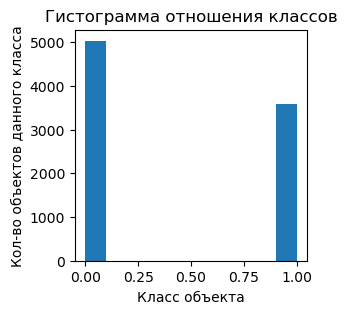

In [7]:
plt.hist(data.is_changed)
plt.xlabel("Класс объекта")
plt.ylabel("Кол-во объектов данного класса")
plt.title("Гистограмма отношения классов");

In [8]:
data = data[data['picture_link'] != "data/clear_data/.DS_Store"]
data = data[data['picture_link'] != "data/stego_data/.DS_Store"]
data.to_csv("data.csv", index=False)

## 3. DataLoader для удобного структурирования данных
<span id="data_loader"></span>

In [76]:
class Dataset(Dataset):
    """Описантельный класс датасета для удобной работы с ним"""

    def __init__(self, csv_file=None, transform=None):
        """
            Args:
                csv_file (string): Путь к csv файлу с разметкой
                transform (callable, optional): Опционально, трансформации применяемые к картинкам
        """
        
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return self.annotations.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_info = self.annotations.iloc[idx]
        image = io.imread(img_info[0])
        label = img_info[1]
        
        if self.transform:
            image = self.transform(image)
                
        sample = torch.tensor([image], dtype=torch.float32), label

        return sample

In [10]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((256, 256)), transforms.ToTensor()])
train_dataset = Dataset(csv_file='data.csv')

train_part = np.arange(0, int(len(train_dataset) * 0.7))
val_part = np.arange(int(len(train_dataset) * 0.7), int(len(train_dataset) * 0.9))
test_part = np.arange(int(len(train_dataset) * 0.9), len(train_dataset))

sampler_to_train = torch.utils.data.SubsetRandomSampler(train_part)
sampler_to_val = torch.utils.data.SubsetRandomSampler(val_part)
sampler_to_test = torch.utils.data.SubsetRandomSampler(test_part)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler_to_train) 
val_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler_to_val)
test_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler_to_test)

torch.Size([64, 1, 256, 256]) tensor(29)


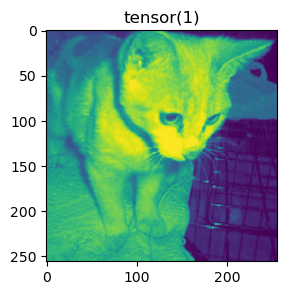

In [12]:
for image, label in train_loader:
    print(torch.tensor(image).shape, label.sum())
    plt.imshow(image[0].transpose(0, -1).transpose(1, 0))
    plt.title(label[0])
    plt.show();
    break

## 4. Нейросеть на torch
<span id="neural_net"></span>

In [13]:
def gaussian(inp: torch.Tensor) -> torch.Tensor:
    """Считает гауссову функцию для каждого входного тензора
    Args:
            inp (torch.Tensor): входной тензор
    Returns:
            torch.Tensor: тензор после применения Гаусса
    """
    
    return torch.exp(-((inp - torch.mean(inp)) ** 2) / (torch.std(inp)) ** 2) 

In [14]:
class ImageProcessing(nn.Module):
    """Считает свёртку с помощью использования пространственного фильтра высоких частот с фиксированным ядром"""

    def __init__(self) -> None:
        super().__init__()
        self.kv_filter = (
            torch.tensor(
                [
                    [-1.0, 2.0, -2.0, 2.0, -1.0],
                    [2.0, -6.0, 8.0, -6.0, 2.0],
                    [-2.0, 8.0, -12.0, 8.0, -2.0],
                    [2.0, -6.0, 8.0, -6.0, 2.0],
                    [-1.0, 2.0, -2.0, 2.0, -1.0],
                ],
                
            ).view(1, 1, 5, 5) / 12.0
        )

    def forward(self, inp: torch.Tensor) -> torch.Tensor:
        """Возвращает тензор, над которым была произведена свертка"""
        return F.conv2d(inp, self.kv_filter)

In [15]:
class ConvPool(nn.Module):
    """
        Данный класс возвращает экземпляр свертки, выстроенной по необходимым параметрам, 
        то есть  схема данного блока это conv -> batch norm -> gaussian -> average pooling
    """

    def __init__(
            self,
            in_channels: int = 16,
            out_channels: int = 32,
            conv_kernel_size: tuple[int, int] = (3, 3),
            conv_stride: int = 1,
            pool_stride: int = 2,
            pool_kernel_size: tuple[int, int] = (3, 3),
            pool_padding: int = 0,
        ) -> None:
        
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=conv_kernel_size,
            stride=conv_stride,
            padding=0,
            bias=True,
        )
        self.pool = nn.AvgPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, inp: torch.Tensor) -> torch.Tensor:
        """Соответсвенно conv->batch norm->activation->average pooling."""
        
        return self.pool(gaussian(self.bn(self.conv(inp))))

In [16]:
class CNN(nn.Module):
    """
        Реализация сверточной нейронной сети
    """

    def __init__(self) -> None:
        super().__init__()
        
        self.layer1 = ConvPool(
            in_channels=1,
            out_channels=16,
            conv_kernel_size=(5, 5),
            pool_kernel_size=(3,3)
        )
        
        self.layer2 = ConvPool(
            in_channels=16,
            out_channels=64,
            conv_kernel_size=(3, 3),
        )
        
        self.layer3 = ConvPool(
            in_channels=64,
            out_channels=128,
            conv_kernel_size=(3, 3),
        )
        
        self.fully_connected = nn.Sequential(
            
            nn.Linear(in_features=100352, out_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=2),
            nn.LogSoftmax(dim=1),
            
        )
        
    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """Вернет логиты для данного изображения"""
        with torch.no_grad():
            out = ImageProcessing()(image)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fully_connected(out)
        return out                

In [17]:
class Evaluation:
    def __init__(self, train_loader, val_loader, test_loader, model, lr=0.02, epoch=15):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.epoch = epoch
        self.optimizer = torch.optim.Adamax(
            self.model.parameters(),
            lr=lr,
            betas=(0.9, 0.999),
            eps=1e-8,
            weight_decay=0,
        )
        self.loss_fn = nn.NLLLoss()
        
    def validation(self):
        accuracy_list = []
        
        for xb, yb in self.val_loader:
            y_pred = self.model(xb).data.max(1)[1]
            accuracy = accuracy_score(y_pred, yb)
            accuracy_list.append(accuracy)
                
        return np.mean(np.array(accuracy_list))
        
    def test(self):
        accuracy_list = []
        
        for xb, yb in self.test_loader:
            y_pred = self.model(xb).data.max(1)[1]
            accuracy = accuracy_score(y_pred, yb)
            accuracy_list.append(accuracy)
                
        return np.mean(np.array(accuracy_list))
        
    def fit(self):
        losses = []
        valid_accuracies = []
        train_accuracies = []
        test_accuracies = []
        
        for i in range(1, self.epoch + 1):
            epoch_train_accuracies = []
            counter = 1
            self.model.train()
            for X, y in tqdm(self.train_loader):
                print(f'Iteration {counter} started')
                counter += 1
                clear_output(wait=True)
                
                self.optimizer.zero_grad()
                y_pred = self.model(X)
                
                loss = self.loss_fn(y_pred, y)
                losses.append(loss.item())  
                print(loss.item())
                
                y_pred = y_pred.data.max(1)[1]
                accuracy = accuracy_score(y_pred, y)
                epoch_train_accuracies.append(accuracy)
                
                loss.backward()
                self.optimizer.step()
                
            print("Starting validation")
            
            self.model.eval()
            valid_accuracy = self.validation()
            train_accuracy = np.mean(np.array(epoch_train_accuracies))
            
            valid_accuracies.append(valid_accuracy)
            train_accuracies.append(train_accuracy)
            
            print("Valid_accuracy in:", valid_accuracy)
            print("Train_accuracy in:", train_accuracy)
            print(f'Epoch {i} is finished!')
            time.sleep(10)
            
        test_accuracy = self.test()  
        
        print(f"Mean loss is: {np.mean(np.array(losses))}")
        print(f"Mean valid_accuracy is: {np.mean(np.array(valid_accuracies))}")
        print(f"Mean train_accuracy is: {np.mean(np.array(train_accuracies))}")
        
        return losses, valid_accuracies, train_accuracies, test_accuracy

In [18]:
net = CNN()

## 5. Обучение и валидация модели
<span id="tests"></span>

In [19]:
evaluation = Evaluation(train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, model=net)

In [20]:
losses, valid_accuracies, train_accuracies, test_accuracy = evaluation.fit()

0.24574565887451172


100%|███████████████████████████████████████████| 95/95 [06:34<00:00,  4.16s/it]


Starting validation
Valid_accuracy in: 0.7569444444444444
Train_accuracy in: 0.9120689655172415
Epoch 15 is finished!
Mean loss is: 3.003420785445916
Mean valid_accuracy is: 0.6456018518518519
Mean train_accuracy is: 0.8368617664851785


In [21]:
torch.save(evaluation.model.state_dict(), "NN_weights")

## 6. Вывод

В процессе выполнения, были выполнены такие шаги, как получение, обработка и классификация данных. Во-первых, мы использовали алгоритм стеганографии, который называется `WOW`, встраивание производилось с параметрами `payload = 0.4`. После разбиения данных на выборки, мы удобно их структурировали и приступили к обучению модели. По итогу имеем такие результаты, изображенные на графике: 

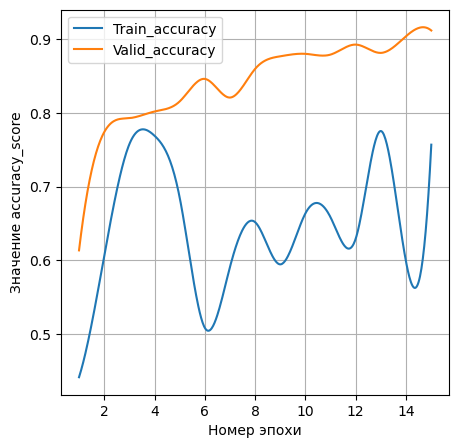

In [197]:
plt.rcParams["figure.figsize"] = (5,5)

X_Y_res_val = make_interp_spline(range(1, 16), valid_accuracies)
X_res_val = np.linspace(1, 15, 500)
Y_res_val = X_Y_res_val(X_res_val)
plt.plot(X_res_val, Y_res_val, label="Train_accuracy")

X_Y_res_train = make_interp_spline(range(1, 16), train_accuracies)
X_res_train = np.linspace(1, 15, 500)
Y_res_train = X_Y_res_train(X_res_train)
plt.plot(X_res_train, Y_res_train, label="Valid_accuracy")

plt.legend()
plt.grid()

plt.ylabel("Значение accuracy_score")
plt.xlabel("Номер эпохи")
plt.show()

In [23]:
print(f"Значение loss по окончании обучения: {np.min(losses)}")
print(f"Значение loss на начале обучения обучения: {np.max(losses)}")
print(f"Значение accuracy_score на test: {test_accuracy}")
print(f"Значение accuracy_score на train: {np.max(train_accuracies)}")
print(f"Значение accuracy_score на valid: {np.max(valid_accuracies)}")

Значение loss по окончании обучения: 0.060231976211071014
Значение loss на начале обучения обучения: 1593.5804443359375
Значение accuracy_score на test: 0.7555803571428571
Значение accuracy_score на train: 0.9120689655172415
Значение accuracy_score на valid: 0.7754629629629629


Тут мы видим, что `accuracy_score` для тренировочной выборки скачет, это из-за того, что нейросети постоянно попадались батчи с новыми и новыми признаками. Но тем не менее, валидационный `accuracy_score` растет постоянно, поэтому можно сказать, что никаких проблем не наблюдается.

###  Итог: payload = 0.4

In [24]:
pd.DataFrame({
    'data_type':['train', 'valid', 'test'],
    'accuracy_score':[np.max(train_accuracies), np.max(valid_accuracies), test_accuracy],
})

,data_type,accuracy_score
0,train,0.912069
1,valid,0.775463
2,test,0.755580


## 6. Тесты на устойчивость
<span id="wow_test"></span>

In [67]:
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    os.system(f"mkdir tests/barrier_tests/stego_payload_{i}")
    os.system(f"mkdir tests/barrier_tests/stego_payload_{i}/images")
    
    os.system(f"mkdir tests/no_barrier_tests/stego_payload_{i}")
    os.system(f"mkdir tests/no_barrier_tests/stego_payload_{i}/images")

### 6.1 Без граней (город, машины)
<span id="wow_test_1"></span>

In [84]:
barriers_pictures_dir = list(filter(lambda x: x!= "clear" and not x.startswith("."), os.listdir("tests/no_barrier_tests")))
clear_data = os.listdir("tests/no_barrier_tests/clear")

for directory in tqdm(barriers_pictures_dir):
    payload = float(directory.split("_")[-1])            
    params = -1              
    
    for img in clear_data:
        filename = os.path.join("tests/no_barrier_tests/clear", img)
        cover = Image.open(filename)
        cover = cover.resize((256,256))

        cover = cover.convert('L')
        cover.save(filename)

        cover = np.array(cover)

        stego, distortion = WOW(cover, payload, params)
        Image.fromarray(np.uint8(stego)).save(os.path.join(f"tests/no_barrier_tests/{directory}/images", img))


100%|█████████████████████████████████████████████| 9/9 [04:26<00:00, 29.62s/it]


In [135]:
end_data = {
    "payload":[],
    "accuracy":[],
}

for directory in tqdm(barriers_pictures_dir):
    path = f"tests/no_barrier_tests/{directory}/"
    filename = f"{path}{'+'.join(directory.split('_')[-1].split('.'))}.csv"
    
    stego_links = list(map(lambda x: path + "images/" + x, os.listdir(path + "images")))
    clear_links = list(filter(lambda y: not y.split("/")[-1].startswith("."), map(lambda x: "tests/no_barrier_tests/clear_for_test/" + x, os.listdir("tests/no_barrier_tests/clear_for_test"))))
    
    
    df = shuffle(pd.DataFrame({
        "picture_link":stego_links + clear_links,
        "is_changed":np.concatenate((np.ones(len(stego_links), dtype=int), np.zeros(len(clear_links), dtype=int)), axis=None) 
    }))
    
    df.to_csv(filename, index=False)
    
    
    test_set = Dataset(csv_file=filename)
    sampler = torch.utils.data.SubsetRandomSampler(np.arange(0, df.picture_link.shape[0]))
    loader = DataLoader(test_set, batch_size=32, sampler=sampler)
    
    t_accuracies = []
    
    for xb, yb in loader:        
        with torch.no_grad():
            y_pred = evaluation.model(xb).data.max(1)[1]
        accuracy = accuracy_score(y_pred, yb)
        t_accuracies.append(accuracy)
    
    end_data["payload"].append(directory.split('_')[-1])
    end_data["accuracy"].append(np.mean(np.array(accuracy)))
        

100%|█████████████████████████████████████████████| 9/9 [00:17<00:00,  1.89s/it]


In [136]:
d = pd.DataFrame(end_data).sort_values(by='payload')
d

,payload,accuracy
3,0.1,0.62500
7,0.2,0.78125
6,0.3,0.78125
5,0.4,0.78125
8,0.5,0.87500
2,0.6,0.71875
1,0.7,0.71875
4,0.8,0.68750
0,0.9,0.84375


### 6.2 С гранями (рис)
<span id="wow_test_2"></span>

In [160]:
barriers_pictures_dir = list(filter(lambda x: x!= "clear" and not x.startswith("."), os.listdir("tests/barrier_tests")))
clear_data = os.listdir("tests/barrier_tests/clear")

for directory in tqdm(barriers_pictures_dir):
    payload = float(directory.split("_")[-1])            
    params = -1              
    
    for img in clear_data:
        filename = os.path.join("tests/barrier_tests/clear", img)
        cover = Image.open(filename)
        cover = cover.resize((256,256))

        cover = cover.convert('L')
        cover.save(filename)

        cover = np.array(cover)

        stego, distortion = WOW(cover, payload, params)
        Image.fromarray(np.uint8(stego)).save(os.path.join(f"tests/barrier_tests/{directory}/images", img))


100%|█████████████████████████████████████████████| 9/9 [04:18<00:00, 28.71s/it]


In [164]:
end_data_g = {
    "payload":[],
    "accuracy":[],
}

for directory in tqdm(barriers_pictures_dir):
    path = f"tests/barrier_tests/{directory}/"
    filename = f"{path}{'+'.join(directory.split('_')[-1].split('.'))}.csv"
    
    stego_links = list(map(lambda x: path + "images/" + x, os.listdir(path + "images")))
    clear_links = list(filter(lambda y: not y.split("/")[-1].startswith("."), map(lambda x: "tests/barrier_tests/clear_for_test/" + x, os.listdir("tests/barrier_tests/clear_for_test"))))
    
    
    df = shuffle(pd.DataFrame({
        "picture_link":stego_links + clear_links,
        "is_changed":np.concatenate((np.ones(len(stego_links), dtype=int), np.zeros(len(clear_links), dtype=int)), axis=None) 
    }))
    
    df.to_csv(filename, index=False)
    
    test_set = Dataset(csv_file=filename)
    sampler = torch.utils.data.SubsetRandomSampler(np.arange(0, df.picture_link.shape[0]))
    loader = DataLoader(test_set, batch_size=32, sampler=sampler)
    
    t_accuracies = []
    
    for xb, yb in loader:        
        with torch.no_grad():
            y_pred = evaluation.model(xb).data.max(1)[1]
        accuracy = accuracy_score(y_pred, yb)
        t_accuracies.append(accuracy)
    
    end_data_g["payload"].append(directory.split('_')[-1])
    end_data_g["accuracy"].append(np.mean(np.array(accuracy)))
        

100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.41s/it]


In [165]:
no_d = pd.DataFrame(end_data_g).sort_values(by='payload')
no_d

,payload,accuracy
3,0.1,0.46875
7,0.2,0.43750
6,0.3,0.43750
5,0.4,0.59375
8,0.5,0.53125
2,0.6,0.53125
1,0.7,0.53125
4,0.8,0.37500
0,0.9,0.68750


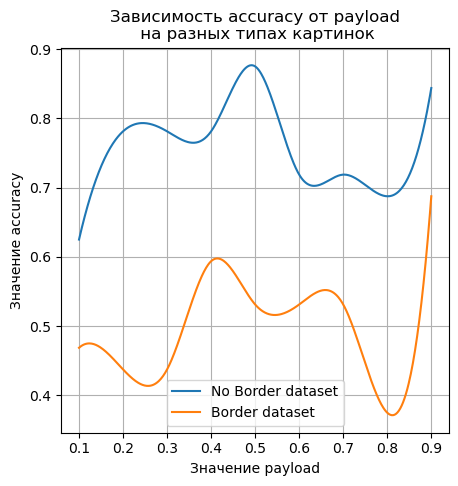

In [198]:
payloads = np.array(list(map(float, d.payload.values)))

X_Y_Spline_d = make_interp_spline(payloads, d.accuracy.values)
X_d = np.linspace(payloads.min(), payloads.max(), 500)
Y_d = X_Y_Spline_d(X_d)

X_Y_Spline_nod = make_interp_spline(payloads, no_d.accuracy.values)
X_nod = np.linspace(payloads.min(), payloads.max(), 500)
Y_nod = X_Y_Spline_nod(X_nod)

plt.plot(X_d, Y_d, label="No Border dataset")
plt.plot(X_nod, Y_nod, label="Border dataset")

plt.xlabel("Значение payload")
plt.ylabel("Значение accuracy")
plt.legend()
plt.grid()
plt.title("Зависимость accuracy от payload\n на разных типах картинок")

plt.show()